<a id="title_ID"></a>
# JWST Pipeline Validation Notebook: 
# spec2, extract1d

<span style="color:red"> **Instruments Affected**</span>: NIRISS

### Table of Contents

<div style="text-align: left"> 
    
<br> [Introduction](#intro)
<br> [JWST CalWG Algorithm](#algorithm)
<br> [Test Description](#description)
<br> [Data Description](#data_descr)
<br> [Imports](#imports)
<br> [Loading the Data](#data_load)
<br> [Run the Pipeline](#pipeline)
<br> [Test1: Inspect Extract1d Arrays](#inspection1)
<br> [Test2: Compare Pipeline vs Manual Flux](#inspection2)
<br> [About This Notebook](#about)
<br>    

</div>

<a id="intro"></a>
# Introduction

This is the validation notebook for the Spec2Pipeline extract1d step. It checks NIRISS 2D extracted spectra for each source and order.

For more information on the pipeline step visit the links below. 

> Step description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/extract_1d/index.html#extract-1d-step

> Pipeline code: https://github.com/spacetelescope/jwst/tree/master/jwst/extract_1d

[Top of Page](#title_ID)

<a id="algorithm"></a>
# JWST CalWG Algorithm

A description of the extract1d algorithm from the JWST CalWG:
https://outerspace.stsci.edu/display/JWSTCC/Vanilla+Spectral+Extraction

[Top of Page](#title_ID)

<a id="description"></a>
# Test Description
- Calibrate WFSS data through spec2
- Visually inspect the extract1d output arrays
- Manually extimate the flux from the photom step output, then compare to extract1d product

[Top of Page](#title_ID)

<a id="data_descr"></a>
# Data Description
The data used for this test are simulations of Abell 2744, created using [MIRaGe](https://github.com/spacetelescope/mirage) for [ERS program 1324](https://www.stsci.edu/jwst/science-execution/approved-programs/dd-ers/program-1324). 
- observations consist of two-point dithers of Abell 2744 for filters F115W, F150W, and F200W
- at each dither point, there is one observation using the GR150R grism, the GR150C grism, and the CLEAR filter
- a set of catalogs from [Morishita et al. (2016)](https://ui.adsabs.harvard.edu/abs/2017ApJ...835..254M/abstract) were used for source flux and morphological parameters
- source spectra are defined as a flat continuum plus emission lines

The [code used to create these simulations](https://github.com/spacetelescope/niriss-pipeline-testing/blob/master/nis_pipe_testing/spec2/simulations/notebook_for_NIRISS_WFSS_simulation.ipynb) was written by Takahiro Morishita.
- Simulations were most recently created on April 26, 2021.

Data are stored in a temporary directory which is created below.

[Top of Page](#title_ID)

In [ ]:
# Create a temporary directory to hold notebook output, and change the working directory to that directory.
use_tempdir = True

from tempfile import TemporaryDirectory
import os
import shutil

if use_tempdir:
    data_dir = TemporaryDirectory()
    # Save original directory
    orig_dir = os.getcwd()
    # Move to new directory
    outdir = data_dir.name
    os.chdir(data_dir.name)

# For info, print out where the script is running
print("Running in {}".format(os.getcwd()))

In [ ]:
# Choose CRDS cache location
use_local_crds_cache = False
crds_cache_tempdir = False
crds_cache_notebook_dir = True
crds_cache_home = False
crds_cache_custom_dir = False
crds_cache_dir_name = ""

if use_local_crds_cache:
    if crds_cache_tempdir:
        os.environ['CRDS_PATH'] = os.path.join(os.getcwd(), "crds")
    elif crds_cache_notebook_dir:
        try:
            os.environ['CRDS_PATH'] = os.path.join(orig_dir, "crds")
        except Exception as e:
            os.environ['CRDS_PATH'] = os.path.join(os.getcwd(), "crds")
    elif crds_cache_home:
        os.environ['CRDS_PATH'] = os.path.join(os.environ['HOME'], 'crds', 'cache')
    elif crds_cache_custom_dir:
        os.environ['CRDS_PATH'] = crds_cache_dir_name

<a id="imports"></a>
# Imports
List the package imports and why they are relevant to this notebook.

* astropy.io for opening fits files
* asdf for modifying parameter reference file
* glob for retrieving the catalog file
* numpy for mathematical computation
* jwst pipeline steps to get direct image through Image3 and dispersed image through Spec2
* matplotlib.pyplot.plt to generate plots


[Top of Page](#title_ID)

In [1]:
import os
import glob

import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.io import ascii
import asdf

from jwst.pipeline import Detector1Pipeline
from jwst.pipeline import Image2Pipeline
from jwst.pipeline import Image3Pipeline
from jwst.pipeline import Spec2Pipeline
from jwst.assign_wcs import AssignWcsStep
from jwst.background import BackgroundStep
from jwst.flatfield import FlatFieldStep
from jwst.extract_2d import Extract2dStep
from jwst.photom import PhotomStep
from jwst.extract_1d import Extract1dStep

2021-04-26 18:00:52,688 - stpipe - WARNING - /Users/jotaylor/miniconda3/envs/jwstdev/lib/python3.8/site-packages/photutils/detection/findstars.py:33: AstropyDeprecationWarning: _StarFinderKernel was moved to the photutils.detection._utils module. Please update your import statement.
  warnings.warn(f'{name} was moved to the {deprecated[name]} module. '



<a id="data_load"></a>
# Loading the Data


### Data for external use: Box method
Artifactory is only accessible to internal users on the STScI network. If you would like to contribute a test notebook that uses externally available data, this test data should be stored in a Box folder instead. The final workflow using Box is still in discussion, but for now you can use a Box folder with the correct permissions set up:

```python
from astropy.utils.data import download_file

main_box_url ="https://data.science.stsci.edu/redirect/JWST/TSO/pipeline_testing_miri_ima_tso/"
filename = 'pipetest_miri_imtso_FULL_10g10i_F770W.fits'
file = download_file(mainurl+filename)
```

Box assigns a default alpha-numerical string as the filename, so you may want to update the filename before processing, or verify that the format is correct. Depending on the data, you can try:

```python
# open file into correct format and write to local disk for processing
hdu = fits.open(file)
hdu.info()
hdu.writeto(filename)
```
or use a ```jwst datamodel```:

```python
from jwst.datamodels import RampModel
model = RampModel(file)
model.save(filename)
```

[Top of Page](#title_ID)

In [2]:
# For now, use data on disk:
gr150r = {'im': '/ifs/jwst/wit/niriss/tmorishita/B75_pipeline_testing/NIRISS-simulation/output/jw00042001001_01101_00001_nis_uncal.fits',
          'gr': '/ifs/jwst/wit/niriss/tmorishita/B75_pipeline_testing/NIRISS-simulation/output/jw00042001001_01101_00002_nis_uncal.fits'}
outdir = '/user/jotaylor/NIRISS/extract1d_notebook'

<a id="pipeline"></a>
# Run the Pipeline

Run all steps necessary to obtain an extract1d product.

[Top of Page](#title_ID)

In [3]:
# Run both direct and dispersed images through Detector1
im = gr150r['im']
gr = gr150r['gr']
im_det1 = Detector1Pipeline.call(im, save_results=True, output_dir=outdir)
im_det1_file = os.path.join(outdir, im_det1.meta.filename)
gr_det1 = Detector1Pipeline.call(gr, save_results=True, output_dir=outdir)
gr_det1_file = os.path.join(outdir, gr_det1.meta.filename)

2021-04-26 18:01:26,750 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_niriss_pars-detector1pipeline_0001.asdf
2021-04-26 18:01:26,874 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2021-04-26 18:01:26,876 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2021-04-26 18:01:26,877 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2021-04-26 18:01:26,879 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2021-04-26 18:01:26,880 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2021-04-26 18:01:26,882 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2021-04-26 18:01:26,883 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2021-04-26 18:01:26,885 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2021-04-26 18:01:26,886 - stpipe.Detector1Pipeline.firstfr

2021-04-26 18:01:27,881 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_niriss_readnoise_0001.fits'.
2021-04-26 18:01:27,931 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2021-04-26 18:01:27,932 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.
2021-04-26 18:01:27,932 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.
2021-04-26 18:01:27,933 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_niriss_saturation_0011.fits'.
2021-04-26 18:01:27,981 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/grp/crds/cache/references/jwst/jwst_niriss_superbias_0029.fits'.
2021-04-26 18:01:28,031 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is '/grp/crds/cache/references/jwst/jwst_niriss_trapdensity_0002.fits'.
2021-04-26

2021-04-26 18:02:55,882 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/ifs/jwst/wit/niriss/tmorishita/B75_pipeline_testing/NIRISS-simulation/output', 'input_trapsfilled': '', 'flag_pers_cutoff': 40.0, 'save_persistence': False, 'save_trapsfilled': True}
2021-04-26 18:03:25,947 - stpipe.Detector1Pipeline.persistence - INFO - Saved model in /user/jotaylor/NIRISS/extract1d_notebook/jw00042001001_01101_00001_nis_trapsfilled.fits
2021-04-26 18:03:25,950 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence done
2021-04-26 18:03:26,062 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 16, 2048, 2048) from jw00042001001_01101_00001_nis_uncal.fits>,).
202

2021-04-26 18:10:15,927 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2021-04-26 18:10:15,928 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2021-04-26 18:10:15,929 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2021-04-26 18:10:15,930 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2021-04-26 18:10:15,931 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2021-04-26 18:10:15,932 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2021-04-26 18:10:15,934 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2021-04-26 18:10:15,935 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2021-04-26 18:10:15,936 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2021-04-26 18:10:15,937 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2021-0

2021-04-26 18:10:16,840 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is '/grp/crds/cache/references/jwst/jwst_niriss_persat_0003.fits'.
2021-04-26 18:10:16,890 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_niriss_readnoise_0001.fits'.
2021-04-26 18:10:16,940 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2021-04-26 18:10:16,941 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.
2021-04-26 18:10:16,942 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.
2021-04-26 18:10:16,943 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_niriss_saturation_0011.fits'.
2021-04-26 18:10:16,990 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/grp/crds/cache/references/jwst/jwst_niriss_superbias_0029.fits'.
2021-04-26 18:10:17,

2021-04-26 18:11:59,827 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2021-04-26 18:11:59,936 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence running with args (<RampModel(1, 16, 2048, 2048) from jw00042001001_01101_00002_nis_uncal.fits>,).
2021-04-26 18:11:59,938 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/ifs/jwst/wit/niriss/tmorishita/B75_pipeline_testing/NIRISS-simulation/output', 'input_trapsfilled': '', 'flag_pers_cutoff': 40.0, 'save_persistence': False, 'save_trapsfilled': True}
2021-04-26 18:12:26,469 - stpipe.Detector1Pipeline.persistence - INFO - Saved model in /user/jotaylor/NIRISS/extract1d_notebook/jw00042001001_01101_00002_nis_trapsfilled.fits
2021-04-2

2021-04-26 18:18:40,573 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


In [4]:
# Run direct images through Image2
im_im2 = Image2Pipeline.call(im_det1_file, save_results=True, output_dir=outdir)

2021-04-26 18:21:36,604 - stpipe - WARNING - /Users/jotaylor/miniconda3/envs/jwstdev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)

2021-04-26 18:21:37,526 - stpipe - INFO - PARS-IMAGE2PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_niriss_pars-image2pipeline_0002.asdf
2021-04-26 18:21:37,637 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.
2021-04-26 18:21:37,639 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2021-04-26 18:21:37,640 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2021-04-26 18:21:37,642 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.
2021-04-26 18:21:37,644 

2021-04-26 18:22:00,781 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  3.609506970 -30.416341182 3.609978673 -30.378900491 3.566857769 -30.378656240 3.566383904 -30.416127547
2021-04-26 18:22:00,782 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  3.609506970 -30.416341182 3.609978673 -30.378900491 3.566857769 -30.378656240 3.566383904 -30.416127547
2021-04-26 18:22:00,782 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs
2021-04-26 18:22:00,851 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done
2021-04-26 18:22:00,911 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(2048, 2048) from jw00042001001_01101_00001_nis_rate.fits>,).
2021-04-26 18:22:00,913 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': Fals

In [8]:
# Change default parameters for source_catalog step
step = Image3Pipeline()
step.export_config('calwebb_image3.asdf')
af = asdf.open("calwebb_image3.asdf")
for i,dct in enumerate(af.tree["steps"]):
    if dct["name"] == "source_catalog":
        af.tree["steps"][i]["parameters"]["kernel_fwhm"] = 1.5
        af.tree["steps"][i]["parameters"]["snr_threshold"] = 20.
        af.tree["steps"][i]["parameters"]["npixels"] = 30
new_config = os.path.join(outdir, "calwebb_image3.asdf")
af.write_to(new_config)

# Run direct images through Image3
im_im3 = Image3Pipeline.call(im_im2, config_file=new_config, save_results=True, output_dir=outdir)

2021-04-26 18:30:04,486 - stpipe - WARNING - /Users/jotaylor/miniconda3/envs/jwstdev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)

2021-04-26 18:30:04,496 - stpipe.Image3Pipeline - INFO - Image3Pipeline instance created.
2021-04-26 18:30:04,497 - stpipe.Image3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.
2021-04-26 18:30:04,499 - stpipe.Image3Pipeline.tweakreg - INFO - TweakRegStep instance created.
2021-04-26 18:30:04,501 - stpipe.Image3Pipeline.skymatch - INFO - SkyMatchStep instance created.
2021-04-26 18:30:04,503 - stpipe.Image3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2021-04-26 18:30:04,504 - stpipe.Image3Pipeline.resample - INFO - Res

2021-04-26 18:30:06,846 - stpipe.Image3Pipeline.skymatch - INFO -  
2021-04-26 18:30:06,846 - stpipe.Image3Pipeline.skymatch - INFO -    "Global" sky value correction: -7.799335803489703e-05 [not converted]
2021-04-26 18:30:06,847 - stpipe.Image3Pipeline.skymatch - INFO -  
2021-04-26 18:30:06,847 - stpipe.Image3Pipeline.skymatch - INFO - ----  Final (match+global) sky for:
2021-04-26 18:30:06,848 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=jw00042001001_01101_00001_nis_cal.fits. Sky background: -7.79934E-05 (old=0, delta=-7.79934E-05)
2021-04-26 18:30:06,848 - stpipe.Image3Pipeline.skymatch - INFO -  
2021-04-26 18:30:06,848 - stpipe.Image3Pipeline.skymatch - INFO - ***** jwst.skymatch.skymatch.match() ended on 2021-04-26 18:30:06.848526
2021-04-26 18:30:06,849 - stpipe.Image3Pipeline.skymatch - INFO - ***** jwst.skymatch.skymatch.match() TOTAL RUN TIME: 0:00:00.134533
2021-04-26 18:30:06,849 - stpipe.Image3Pipeline.skymatch - INFO -  
2021-04-26 18:30:06,851 - stpipe.Ima

In [9]:
# The source catalog file must be added to the spectral rate file
scatfile = glob.glob(os.path.join(outdir, "*.ecsv"))[0]
with fits.open(gr_det1_file, mode="update") as hdulist:
    hdr0 = hdulist[0].header
    hdr0.set("SCATFILE", scatfile)
# Print the catalog for convenience
cat = ascii.read(scatfile)
cat

2021-04-26 18:31:04,138 - stpipe - WARNING - /Users/jotaylor/miniconda3/envs/jwstdev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



id,xcentroid,ycentroid,sky_centroid,aper_bkg_flux,aper_bkg_flux_err,aper30_flux,aper30_flux_err,aper50_flux,aper50_flux_err,aper70_flux,aper70_flux_err,aper_total_flux,aper_total_flux_err,aper30_abmag,aper30_abmag_err,aper50_abmag,aper50_abmag_err,aper70_abmag,aper70_abmag_err,aper_total_abmag,aper_total_abmag_err,aper30_vegamag,aper30_vegamag_err,aper50_vegamag,aper50_vegamag_err,aper70_vegamag,aper70_vegamag_err,aper_total_vegamag,aper_total_vegamag_err,CI_30_50,CI_50_70,CI_30_70,is_star,sharpness,roundness,nn_dist,nn_abmag,isophotal_flux,isophotal_flux_err,isophotal_abmag,isophotal_abmag_err,isophotal_vegamag,isophotal_vegamag_err,isophotal_area,semimajor_sigma,semiminor_sigma,ellipticity,orientation,sky_orientation,sky_bbox_ll,sky_bbox_ul,sky_bbox_lr,sky_bbox_ur
,pix,pix,"deg,deg",Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,,,,,,,,,,,,,,,,,,,,,,,pix,,Jy,Jy,,,,,pix2,pix,pix,,deg,deg,"deg,deg","deg,deg","deg,deg","deg,deg"
int64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float32,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object,object
1,1892.5317,608.2015,"3.5696535338594098,-30.405069615427667",1.284603e-06,nan,6.209435e-06,nan,1.324100e-05,nan,2.299152e-05,nan,3.367241e-05,nan,21.917370,nan,21.095198,nan,20.496081,nan,20.081814,nan,20.208090,nan,19.385918,nan,18.786801,nan,18.372534,nan,0.8222,0.5991,1.4213,True,0.738536,0.039396,687.209825,19.966451,2.420204e-04,nan,17.940370,nan,16.231090,nan,1599.0,5.747916,4.847412,0.156666,43.165368,133.782606,"3.570135169827537,-30.40548810663636","3.5701458010257614,-30.404649421742704","3.5691416027034144,-30.405478734397523","3.5691522424330087,-30.404640049587844"
2,1206.5319,648.9642,"3.5841646555421085,-30.404462409045237",1.252135e-06,nan,6.750555e-06,nan,1.425604e-05,nan,2.556897e-05,nan,3.744723e-05,nan,21.826651,nan,21.015003,nan,20.380717,nan,19.966451,nan,20.117371,nan,19.305723,nan,18.671437,nan,18.257171,nan,0.8116,0.6343,1.4459,True,0.720732,0.134855,687.209825,20.081814,2.586252e-04,nan,17.868323,nan,16.159043,nan,1662.0,5.860831,4.923301,0.159965,43.063250,133.680487,"3.584646180451615,-30.404894753208094","3.584656915370608,-30.404037834807642","3.583652617905263,-30.404885490810454","3.5836633615411153,-30.404028572492027"
3,372.8575,976.1121,"3.6018618465484966,-30.398660847452778",1.499076e-06,nan,6.998752e-06,nan,1.403292e-05,nan,2.605910e-05,nan,3.816505e-05,nan,21.787449,nan,21.032130,nan,20.360102,nan,19.945835,nan,20.078169,nan,19.322850,nan,18.650822,nan,18.236555,nan,0.7553,0.6720,1.4273,True,0.765871,0.462026,754.653089,19.188039,2.744904e-04,nan,17.803682,nan,16.094402,nan,1722.0,5.837371,4.905624,0.159618,43.619927,134.237164,"3.6023502693886966,-30.399095886656003","3.6023610734186193,-30.398220734487484","3.6013356257989204,-30.3990865639465","3.6013464389196517,-30.39821141185877"
4,1091.5130,1399.9379,"3.586767330981001,-30.390793068330836",1.379165e-06,nan,8.384291e-06,nan,1.751393e-05,nan,3.052949e-05,nan,4.471220e-05,nan,21.591334,nan,20.791541,nan,20.188201,nan,19.773935,nan,19.882054,nan,19.082261,nan,18.478921,nan,18.064655,nan,0.7998,0.6033,1.4031,True,0.748328,0.260238,518.385409,19.188039,2.691290e-04,nan,17.825099,nan,16.115819,nan,1693.0,5.725775,4.825672,0.157202,43.121497,133.738735,"3.5872695422260086,-30.39122511584709","3.5872804805063865,-30.3903499649194","3.5862549818046983,-30.391215676580124","3.5862659291742824,-30.390340525737294"
5,653.2237,1676.7518,"3.5960939009567987,-30.385831968817666",4.219971e-07,nan,2.048877e-05,nan,3.524394e-05,nan,5.236946e-05,nan,7.669810e-05,nan,20.621210,nan,20.032289,nan,19.602305,nan,19.188039,nan,18.911930,nan,18.323009,nan,17.893025,nan,17.478759,nan,0.5889,0.4300,1.0189,True,0.898043,-0.164700,396.98749

In [10]:
# Run dispersed image through spec2, step by step
#gr_1d = Spec2Pipeline.call(gr_det1_file, save_results=True, output_dir=outdir)
tmp0 = AssignWcsStep.call(gr_det1_file)
tmp1 = BackgroundStep.call(tmp0, [])
tmp2 = FlatFieldStep.call(tmp1)
tmp3 = Extract2dStep.call(tmp2)
gr_photom = PhotomStep.call(tmp3)

gr_1d = Extract1dStep.call(gr_photom)

2021-04-26 18:31:37,487 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.
2021-04-26 18:31:37,567 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args ('/user/jotaylor/NIRISS/extract1d_notebook/jw00042001001_01101_00002_nis_rate.fits',).
2021-04-26 18:31:37,568 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}
2021-04-26 18:31:41,422 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs
2021-04-26 18:31:41,426 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done
2021-04-26 18:31:41,435 - stpipe.BackgroundStep -

2021-04-26 18:32:11,452 - stpipe.PhotomStep - INFO - Working on slit 5, order 1
2021-04-26 18:32:11,453 - stpipe.PhotomStep - INFO - PHOTMJSR value: 61.2501
2021-04-26 18:32:11,456 - stpipe.PhotomStep - INFO - Working on slit 6, order 1
2021-04-26 18:32:11,457 - stpipe.PhotomStep - INFO - PHOTMJSR value: 61.2501
2021-04-26 18:32:11,461 - stpipe.PhotomStep - INFO - Working on slit 7, order 1
2021-04-26 18:32:11,461 - stpipe.PhotomStep - INFO - PHOTMJSR value: 61.2501
2021-04-26 18:32:11,466 - stpipe.PhotomStep - INFO - Step PhotomStep done
2021-04-26 18:32:11,501 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.
2021-04-26 18:32:11,585 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args (<MultiSlitModel from jw00042001001_01101_00002_nis_rate.fits>,).
2021-04-26 18:32:11,587 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model

In [ ]:
# Currently not in use

# Write photom step and extrac1d step outputs to files
#gr_photom_file = gr_photom.meta.filename.replace("rate", "photom")
#gr_1d_file = gr_1d.meta.filename.replace("rate", "extract1d")
#gr_photom.to_fits(gr_photom_file, overwrite=True)
#gr_1d.to_fits(gr_1d_file, overwrite=True)

### Print and plot all the columns in the extract_1d product

2021-04-26 18:33:42,365 - stpipe - WARNING - /Users/jotaylor/miniconda3/envs/jwstdev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Extension=5
WAVELENGTH: [2.38149023 2.37680888 2.37212801 2.36744714 2.3627665  2.35808563
 2.35340476 2.34872413 2.34404325 2.33936238 2.33468103 2.33000016
 2.32531953 2.32063866 2.31595778 2.31127715 2.30659628 2.30191493
 2.29723406 2.29255319 2.28787231 2.28319144 2.27851081 2.27382994
 2.26914907 2.26446772 2.25978684 2.25510621 2.25042534 2.24574447
 2.24106383 2.23638296 2.23170161 2.22702074 2.22233987 2.21765924
 2.21297836 2.20829749 2.20361686 2.19893599 2.19425511 2.18957376
 2.18489289 2.18021226 2.17553139 2.17085052 2.16616988 2.16148901
 2.15680766 2.15212679 2.14744592 2.14276528 2.13808441 2.13340354
 2.12872291 2.1240418  2.11936045 2.11467957 2.10999894 2.10531807
 2.1006372  2.09595656 2.09127569 2.08659434 2.08191347 2.0772326
 2.07255197 2.06787109 2.06319022 2.05850959 2.05382872 2.04914784
 2.0444665  2.03978562 2.03510499 2.03042412 2.02574325 2.02106261
 2.01638174 2.01170039 2.00701952 2.00233865 1.9976579  1.99297702
 1.98829615 1.9836154  1.97893453 1.974

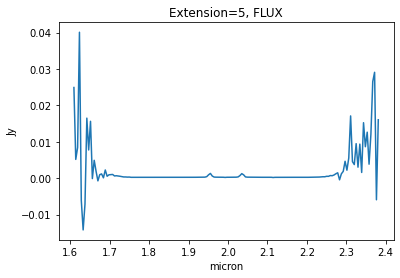

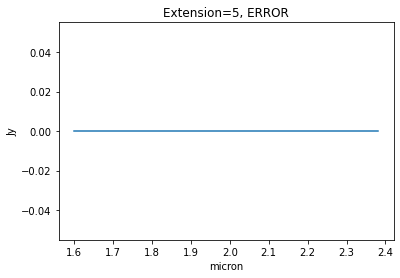

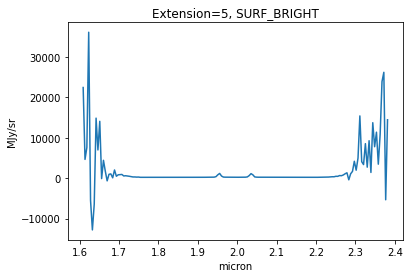

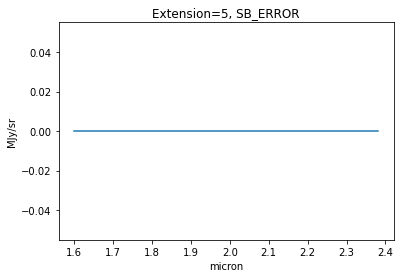

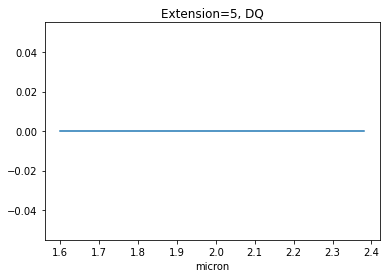

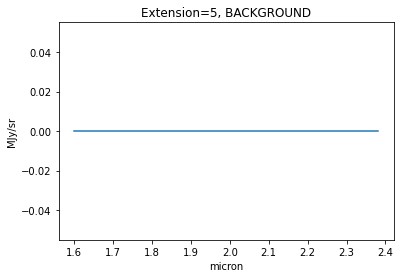

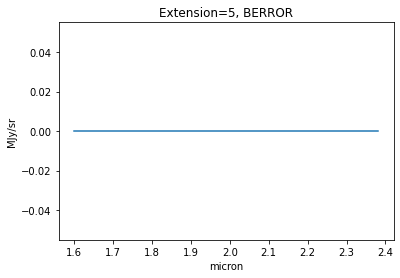

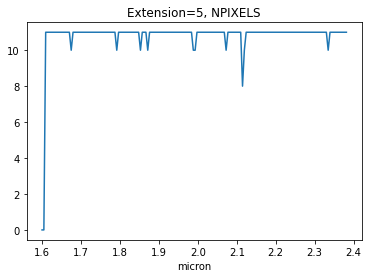

In [13]:
columns = ['WAVELENGTH', 'FLUX', 'ERROR', 'SURF_BRIGHT', 'SB_ERROR', 'DQ', 'BACKGROUND', 'BERROR', 'NPIXELS']
#exts = np.arange(len(gr_1d.spec))
exts = [5]
order = 1
for ext in exts:
    if gr_1d.spec[ext].spectral_order != order:
        print(f"Extension={ext} is not of specified order={order}, aborting")
    else:
        print(f"Extension={ext}")
    for col in columns:        
        print(f"{col}: {gr_1d.spec[ext].spec_table[col]}")
        unit = gr_1d.spec[ext].spec_table.columns[col].unit
        if col != "WAVELENGTH":
            fig, ax = plt.subplots(1)
            ax.plot(gr_1d.spec[ext].spec_table['WAVELENGTH'], gr_1d.spec[ext].spec_table[col])
            ax.set_title(f"Extension={ext}, {col}")
            ax.set_xlabel("micron")
            ax.set_ylabel(unit)
    print("")

<a id="inspection1"></a>
# Visually inspect diagnostic arrays and plots above
Do they look appropriate?

[Top of Page](#title_ID)

### Now manually estimate the flux and compare to the pipeline product

In [14]:
# Manually estimate the flux
pixar_sr = gr_photom.slits[ext].meta.photometry.pixelarea_steradians
leng = gr_1d.spec[ext].spec_table['WAVELENGTH'].shape[0]
wave_1d_man = np.zeros(leng, 'float32')
flux_1d_man = np.zeros(leng, 'float32')

for i in range(leng):
    flux_1d_man[i] = np.sum(gr_photom.slits[ext].data[i,:]) * pixar_sr * 1e6
    wave_1d_man[i] = np.median(gr_photom.slits[ext].wavelength[i,:])

2021-04-26 18:33:54,764 - stpipe - WARNING - /Users/jotaylor/miniconda3/envs/jwstdev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



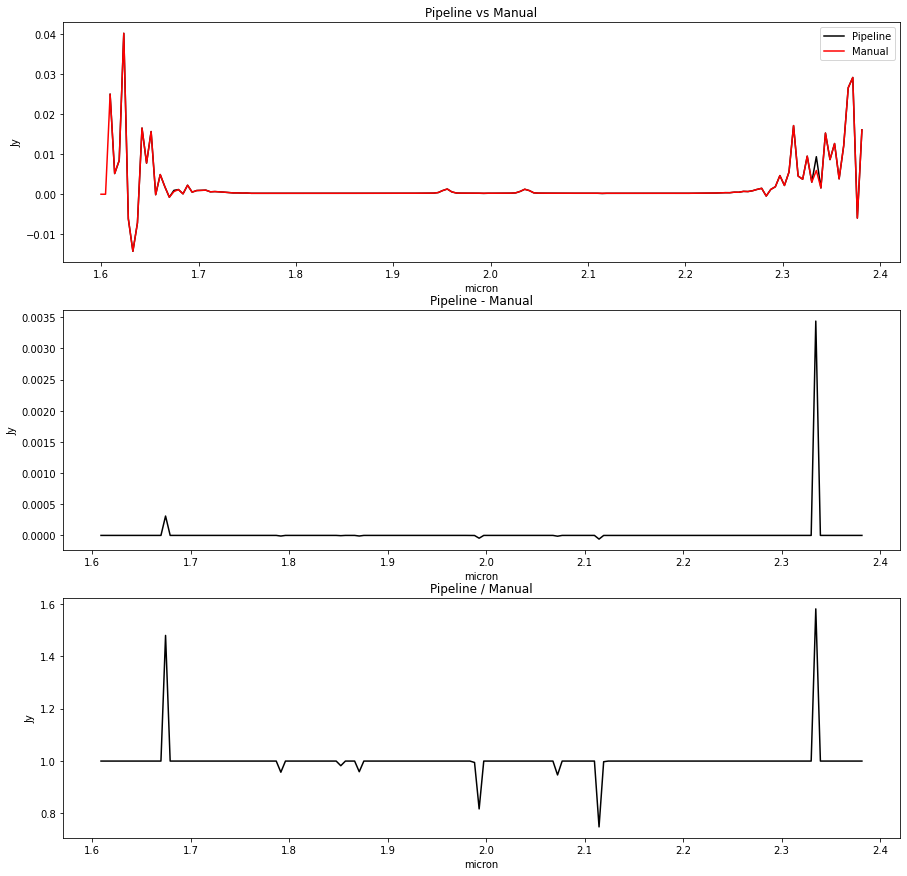

In [15]:
# Compare the manually estimated flux to the extract1d product's flux
fig, axes = plt.subplots(3,1, figsize=(15, 15))
wave_1d_pipe = gr_1d.spec[ext].spec_table['WAVELENGTH']
flux_1d_pipe = gr_1d.spec[ext].spec_table['FLUX']
axes[0].plot(wave_1d_pipe, flux_1d_pipe, color='k', label='Pipeline')
axes[0].plot(wave_1d_man, flux_1d_man, color='r', label='Manual')
axes[0].set_title("Pipeline vs Manual")
axes[0].legend(loc="best")

axes[1].plot(wave_1d_pipe, flux_1d_pipe-flux_1d_man, color='k', label='Pipeline')
axes[1].set_title("Pipeline - Manual")

axes[2].plot(wave_1d_pipe, flux_1d_pipe/flux_1d_man, color='k', label='Pipeline')
axes[2].set_title("Pipeline / Manual")

unit = gr_1d.spec[ext].spec_table.columns['FLUX'].unit
for ax in axes:
    ax.set_ylabel(unit)
    ax.set_xlabel("micron")

<a id="inspection2"></a>
# Visually inspect comparison plots above
Do they look appropriate?

[Top of Page](#title_ID)

<a id="about_ID"></a>
## About this Notebook
**Authors:** Takahiro Morishita, Jo Taylor
<br>**Updated On:** April 26, 2021

[Top of Page](#title_ID)
<img style="float: right;" src="./stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="stsci_pri_combo_mark_horizonal_white_bkgd" width="200px"/> 